# Figure 4
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py # for reading .mat files
from scipy.stats import kde
from scipy.stats import ks_2samp
from scipy import stats
import matplotlib as mpl

Data locations

In [2]:
loc_probs_lens = "../Data/Probabilities/LENS/"
loc_probs_cmip = "../Data/Probabilities/CMIP5/"
loc_probs_obs = "../Data/Probabilities/"

loc_pct_lens = "../Data/PercentChanges/LENS/"
loc_pct_cmip = "../Data/PercentChanges/CMIP5/"

SOM parameters and other stuff

In [3]:
ssn = "DJF"
reanalysis = "R2"

nrow = 2
ncol = 2
nnode = nrow*ncol

latmin = 30
latmax = 65
lonmin = 60
lonmax = 145
latctr = ((latmax-latmin)/2) + latmin
lonctr = ((lonmax-lonmin)/2) + lonmin

year_begin = 1979
year_end = 2016

runmean_length = 3

Runs and models

In [4]:
runs = ["001","002","003","004","005","006","007","008","009", \
        "010","011","012","013","014","015","016","017","018", \
        "019","020","021","022","023","024","025","026","027", \
        "028","029","030","031","032","033","034","035"]

nruns = len(runs)

models = ["ACCESS1-0","ACCESS1-3","CNRM-CM5","GFDL-CM3","GFDL-ESM2M","GFDL-ESM2G","MIROC5","MIROC-ESM-CHEM","MRI-CGCM3","MRI-ESM1"]
nmodels = len(models)

Function for resampling LENS standard deviations

In [5]:
np.random.seed(100)

def lens_std_resample(lens_var,new_size,nboot):
    
    lens_stds = np.zeros(nboot)
    for nb in np.arange(0,nboot,1):
        lens_stds[nb] = np.std(lens_var[np.random.randint(0,len(lens_var),new_size)])
        
    return(lens_stds)

#### Analysis

Observed haze probability

In [6]:
y1_met = 1981
y2_met = 2010
y1_aq = 2008
y2_aq = 2020

# haze given bins, etc
joint_probs_file = xr.open_dataset(loc_probs_obs+"SOM_PC1_AQ_JOINT_PROBS_"+str(y1_aq)+"-"+str(y2_aq)+".nc")
joint_probs_obs = xr.DataArray(joint_probs_file.data_vars["PROBS"])
joint_probs_median = joint_probs_obs.median(dim="boot")
haze_bins_flat = joint_probs_median.values.flatten()

# prob pc1/node
joint_occurrence_file = xr.open_dataset(loc_probs_obs+"SOM_PC1_JOINT_OCCURRENCE_"+str(y1_met)+"-"+str(y2_met)+".nc")
joint_occurrence = xr.DataArray(joint_occurrence_file.data_vars["PROBS"])
joint_occurrence_median = joint_occurrence.median(dim="boot")

p_haze = (joint_probs_obs * joint_occurrence).sum(dim=["node","bin"])

Now modeled haze change data

In [7]:
joint_occ_file_lens = xr.open_dataset(loc_probs_lens+"LENS_SOM_PC1_JOINT_OCCURRENCE_1981CLM_TEMPTARGET.nc")
joint_occ_file_cmip = xr.open_dataset(loc_probs_cmip+"CMIP5_SOM_PC1_JOINT_OCCURRENCE_1981CLM_TEMPTARGET.nc")

joint_occ_lens = xr.DataArray(joint_occ_file_lens.data_vars["FRACTION"])
joint_occ_cmip = xr.DataArray(joint_occ_file_cmip.data_vars["FRACTION"])

p_haze_lens_file = xr.open_dataset(loc_probs_lens+"LENS_HAZE_FRACTION_1981CLM_TEMPTARGET.nc")
p_haze_cmip_file = xr.open_dataset(loc_probs_cmip+"CMIP5_HAZE_FRACTION_1981CLM_TEMPTARGET.nc")

p_haze_lens = xr.DataArray(p_haze_lens_file.data_vars["FRACTION"])
p_haze_cmip = xr.DataArray(p_haze_cmip_file.data_vars["FRACTION"])

joint_occ_file_lens_change = xr.open_dataset(loc_probs_lens+"LENS_SOM_PC1_JOINT_OCCURRENCE_CHANGE_1981CLM_TEMPTARGET.nc")
joint_occ_file_cmip_change = xr.open_dataset(loc_probs_cmip+"CMIP5_SOM_PC1_JOINT_OCCURRENCE_CHANGE_1981CLM_TEMPTARGET.nc")

joint_occ_lens_change = xr.DataArray(joint_occ_file_lens_change.data_vars["FRACTION"])*100
joint_occ_cmip_change = xr.DataArray(joint_occ_file_cmip_change.data_vars["FRACTION"])*100

Number of days

In [8]:
ndays_yr = 31 + 31 + 28
nyears = 10
ndays = ndays_yr*nyears

Haze change statistics

In [9]:
haze_change_lens = (p_haze_lens - np.median(p_haze))*100
haze_change_cmip = (p_haze_cmip - np.median(p_haze))*100
haze_change_lens_em = haze_change_lens.mean(dim="run")
haze_change_lens_sd = haze_change_lens.std(dim="run")
haze_change_cmip_em = haze_change_cmip.mean(dim="model")
haze_change_cmip_sd = haze_change_cmip.std(dim="model")

Now changes in each of the components of haze risk change

In [10]:
node_occ_file_lens_change = xr.open_dataset(loc_probs_lens+"LENS_SOM_OCCURRENCE_CHANGE_1981CLM_TEMPTARGET.nc")
node_occ_file_cmip_change = xr.open_dataset(loc_probs_cmip+"CMIP5_SOM_OCCURRENCE_CHANGE_1981CLM_TEMPTARGET.nc")

node_occ_lens_change = xr.DataArray(node_occ_file_lens_change.data_vars["FRACTION"])*100
node_occ_cmip_change = xr.DataArray(node_occ_file_cmip_change.data_vars["FRACTION"])*100

pc1_occ_file_lens_change = xr.open_dataset(loc_probs_lens+"LENS_PC1_OCCURRENCE_CHANGE_1981CLM_TEMPTARGET.nc")
pc1_occ_file_cmip_change = xr.open_dataset(loc_probs_cmip+"CMIP5_PC1_OCCURRENCE_CHANGE_1981CLM_TEMPTARGET.nc")

pc1_occ_lens_change = xr.DataArray(pc1_occ_file_lens_change.data_vars["FRACTION"])*100
pc1_occ_cmip_change = xr.DataArray(pc1_occ_file_cmip_change.data_vars["FRACTION"])*100

Ensemble means and standard deviations

In [11]:
node_change_lens_em = node_occ_lens_change.mean(dim="run")
node_change_lens_sd = node_occ_lens_change.std(dim="run")
node_change_cmip_em = node_occ_cmip_change.mean(dim="model")
node_change_cmip_sd = node_occ_cmip_change.std(dim="model")

pc1_change_lens_em = pc1_occ_lens_change.mean(dim="run")
pc1_change_lens_sd = pc1_occ_lens_change.std(dim="run")
pc1_change_cmip_em = pc1_occ_cmip_change.mean(dim="model")
pc1_change_cmip_sd = pc1_occ_cmip_change.std(dim="model")

joint_change_lens_em = joint_occ_lens_change.mean(dim="run")
joint_change_lens_sd = joint_occ_lens_change.std(dim="run")
joint_change_cmip_em = joint_occ_cmip_change.mean(dim="model")
joint_change_cmip_sd = joint_occ_cmip_change.std(dim="model")

Temp targets

In [12]:
temp_targets = node_change_lens_em.coords["temp_target"].values

Percent change in individual ingredients

In [13]:
y1 = 1981
y2 = 2010 #2016

pct_ingredients_lens = xr.DataArray(xr.open_dataset(loc_pct_lens+"LENS_INGREDIENTS_PCTCHANGE_TEMP_BASE"+str(y1)+"-"+str(y2)+".nc").data_vars["var_percent_change"])
pct_ingredients_cmip = xr.DataArray(xr.open_dataset(loc_pct_cmip+"CMIP5_INGREDIENTS_PCTCHANGE_TEMP_BASE"+str(y1)+"-"+str(y2)+".nc").data_vars["var_percent_change"])

In [14]:
lens_ingred_sd = pct_ingredients_lens.std(dim="run")
cmip_ingred_sd = pct_ingredients_cmip.std(dim="model")

Variability in haze risk and ingredient change

In [15]:
haze_var_lens = xr.DataArray(xr.open_dataset(loc_probs_lens+"LENS_HAZE_FRACTION_STD_"+str(y1)+"CLM_TEMPTARGET.nc").data_vars["STD"])
haze_var_cmip = xr.DataArray(xr.open_dataset(loc_probs_cmip+"CMIP5_HAZE_FRACTION_STD_"+str(y1)+"CLM_TEMPTARGET.nc").data_vars["STD"])

In [16]:
node_var_lens = xr.DataArray(xr.open_dataset(loc_probs_lens+"LENS_SOM_OCCURRENCE_STD_"+str(y1)+"CLM_TEMPTARGET.nc").data_vars["STD"])
node_var_cmip = xr.DataArray(xr.open_dataset(loc_probs_cmip+"CMIP5_SOM_OCCURRENCE_STD_"+str(y1)+"CLM_TEMPTARGET.nc").data_vars["STD"])

In [17]:
ingred_var_lens = xr.DataArray(xr.open_dataset(loc_probs_lens+"LENS_INGREDIENTS_STD_TEMP_BASE"+str(y1)+"-"+str(y2)+".nc").data_vars["var_std"])
ingred_var_cmip = xr.DataArray(xr.open_dataset(loc_probs_cmip+"CMIP5_INGREDIENTS_STD_TEMP_BASE"+str(y1)+"-"+str(y2)+".nc").data_vars["var_std"])

Plot

In [18]:
upperp = 75
lowerp = 25
lw = 3

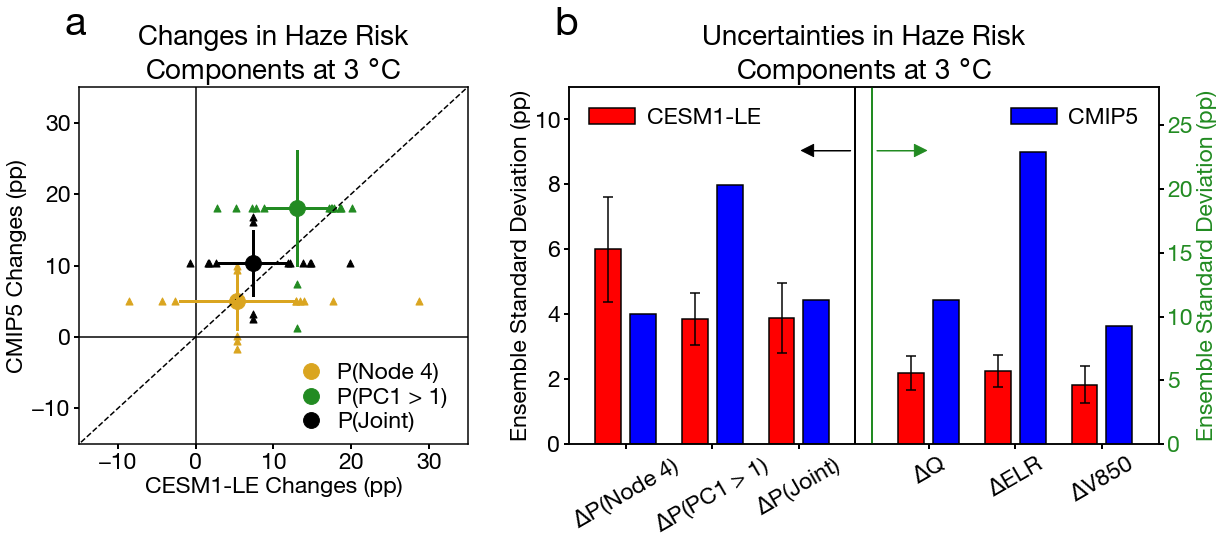

In [19]:
fig = plt.figure(figsize=(20,8))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 23.0
rcParams["axes.linewidth"] = 1.5
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 2

# three panels only, since we'll just use 3C as the temperature target
# and put the other two in the SM

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.1,right=0.37,top=0.82,bottom=0.2,wspace=0.25,hspace=0.2)

ax = plt.subplot(gs1[0,0])

target = 3
tt = list(temp_targets).index(target)
plt.plot([-100,100],[-100,100],linewidth=1.5,linestyle="--",color="black")
plt.axhline(y=0,linewidth=1.5,linestyle="-",color="black")
plt.axvline(x=0,linewidth=1.5,linestyle="-",color="black")
    
for ii in np.arange(0,3,1):
    if ii == 0:
        lens_change = node_occ_lens_change[:,tt,3]
        cmip_change = node_occ_cmip_change[:,tt,3]
        lens_em = node_change_lens_em[tt,3]
        lens_sd = node_change_lens_sd[tt,3]
        cmip_em = node_change_cmip_em[tt,3]
        cmip_sd = node_change_cmip_sd[tt,3]
        colii = "goldenrod"
        lblii = "P(Node 4)"
    elif ii == 1:
        lens_change = pc1_occ_lens_change[:,tt,3]
        cmip_change = pc1_occ_cmip_change[:,tt,3]
        lens_em = pc1_change_lens_em[tt,3]
        lens_sd = pc1_change_lens_sd[tt,3]
        cmip_em = pc1_change_cmip_em[tt,3]
        cmip_sd = pc1_change_cmip_sd[tt,3]
        colii = "forestgreen"
        lblii = "P(PC1 > 1)"
    else:
        lens_change = joint_occ_lens_change[:,tt,3,3]
        cmip_change = joint_occ_cmip_change[:,tt,3,3]
        lens_em = joint_change_lens_em[tt,3,3]
        lens_sd = joint_change_lens_sd[tt,3,3]
        cmip_em = joint_change_cmip_em[tt,3,3]
        cmip_sd = joint_change_cmip_sd[tt,3,3]
        colii = "black"
        lblii = "P(Joint)"
    
    plt.scatter(lens_em,cmip_em,color=colii,s=250,label=lblii)
    x1x2 = [lens_em-lens_sd,lens_em+lens_sd]
    y1y2 = [cmip_em-cmip_sd,cmip_em+cmip_sd]
    plt.plot(x1x2,[cmip_em,cmip_em],color=colii,linewidth=lw,linestyle="-")
    plt.plot([lens_em,lens_em],y1y2,color=colii,linewidth=lw,linestyle="-")
    
    for rr in np.arange(0,len(runs),1):
        lens_change_run = lens_change[rr]
        if ((lens_change_run < (lens_em-lens_sd)) | (lens_change_run > (lens_em+lens_sd))):
            plt.scatter(lens_change_run,cmip_em,color=colii,s=50,marker="^")
            
    for mm in np.arange(0,len(models),1):
        cmip_change_model = cmip_change[mm]
        if ((cmip_change_model < (cmip_em-cmip_sd)) | (cmip_change_model > (cmip_em+cmip_sd))):
            plt.scatter(lens_em,cmip_change_model,color=colii,s=50,marker="^")
                
    
plt.xlim([-15,35])
plt.ylim([-15,35])
    
plt.xlabel("CESM1-LE Changes (pp)")
plt.ylabel("CMIP5 Changes (pp)")
plt.legend(loc="lower right",frameon=False,ncol=1,scatteryoffsets=[0.5],markerscale=1,handletextpad=0.1,labelspacing=0.2,columnspacing=0.2,bbox_to_anchor=(0,-0.025,1,1))
plt.title("Changes in Haze Risk"+"\n"+"Components at "+str(target)+" $\degree$C")



# Bar plot of uncertainties

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.44,right=0.85,top=0.82,bottom=0.2,wspace=0.25,hspace=0.2)


ax = plt.subplot(gs2[0,0])

lens_node_sd = node_change_lens_sd[tt,3]
cmip_node_sd = node_change_cmip_sd[tt,3]
lens_node_sd_resample = lens_std_resample(node_occ_lens_change[:,tt,3].values,10,100)
    
lens_pc1_sd = pc1_change_lens_sd[tt,3]
cmip_pc1_sd = pc1_change_cmip_sd[tt,3]
lens_pc1_sd_resample = lens_std_resample(pc1_occ_lens_change[:,tt,3].values,10,100)

lens_joint_sd = joint_change_lens_sd[tt,3,3]
cmip_joint_sd = joint_change_cmip_sd[tt,3,3]
lens_joint_sd_resample = lens_std_resample(joint_occ_lens_change[:,tt,3,3].values,10,100)

lens_q_sd_resample = lens_std_resample(pct_ingredients_lens[0,:,tt].values,10,100)
lens_elr_sd_resample = lens_std_resample(pct_ingredients_lens[1,:,tt].values,10,100)
lens_v850_sd_resample = lens_std_resample(pct_ingredients_lens[2,:,tt].values,10,100)

cmip_sds = cmip_ingred_sd[:,tt].values

#lens_hgts = [np.median(lens_haze_sd_resample),np.median(lens_node_sd_resample),np.median(lens_pc1_sd_resample),np.median(lens_joint_sd_resample)]
lens_hgts = [np.median(lens_node_sd_resample),np.median(lens_pc1_sd_resample),np.median(lens_joint_sd_resample),
             np.median(lens_q_sd_resample),np.median(lens_elr_sd_resample),np.median(lens_v850_sd_resample)]
lens_yerr = [np.std(lens_node_sd_resample),np.std(lens_pc1_sd_resample),np.std(lens_joint_sd_resample),
             np.std(lens_q_sd_resample),np.std(lens_elr_sd_resample),np.std(lens_v850_sd_resample)]

cmip_bar1 = plt.bar(x=[0.7,1.7,2.7],
                   height=[cmip_node_sd,cmip_pc1_sd,cmip_joint_sd],
                   width=0.3,color="blue",edgecolor="black",linewidth=1.5)
lens_bar1 = plt.bar(x=[0.3,1.3,2.3],height=lens_hgts[:3],
                    width=0.3,color="red",edgecolor="black",linewidth=1.5,yerr=lens_yerr[:3],error_kw={"capsize":5,"elinewidth":1.5,"capthick":1.5})

plt.ylim([0,11])
plt.ylabel("Ensemble Standard Deviation (pp)")

plt.xticks(ticks=[0.5,1.5,2.5,4,5,6],
           labels=["$\Delta$P(Node 4)","$\Delta$P(PC1 > 1)","$\Delta$P(Joint)","$\Delta$Q","$\Delta$ELR","$\Delta$V850"],
           rotation=30,ha="center")


ax2 = ax.twinx()

cmip_bar2 = plt.bar(x=[4.2,5.2,6.2],
                   height=[cmip_sds[0],cmip_sds[1],cmip_sds[2]],
                   width=0.3,color="blue",label="CMIP5",edgecolor="black",linewidth=1.5)
lens_bar2 = plt.bar(x=[3.8,4.8,5.8],height=lens_hgts[3:],
                    width=0.3,color="red",label="CESM1-LE",edgecolor="black",linewidth=1.5,yerr=lens_yerr[3:],error_kw={"capsize":5,"elinewidth":1.5,"capthick":1.5})

plt.ylim([0,28])
plt.ylabel("Ensemble Standard Deviation (pp)", color="forestgreen")
plt.yticks(color="forestgreen")

p1 = plt.legend([lens_bar1],["CESM1-LE"],loc="upper left",frameon=False,markerscale=1,handletextpad=0.5,handlelength=2,ncol=2)
ax2 = plt.gca().add_artist(p1)
p2 = plt.legend([cmip_bar1],["CMIP5"],loc="upper right",frameon=False,markerscale=1,handletextpad=0.5,handlelength=2,ncol=2)



plt.title("Uncertainties in Haze Risk"+"\n"+"Components at "+str(target)+" $\degree$C")
plt.axvline(x=3.15,linewidth=2,linestyle="-",color="black")
plt.axvline(x=3.35,linewidth=2,linestyle="-",color="forestgreen")

# manually draw arrows
plt.arrow(3.4,23,0.5,0,color="forestgreen")
plt.scatter(3.9,23.05,s=150,marker=">",color="forestgreen")
plt.arrow(3.1,23,-0.5,0,color="black")
plt.scatter(2.6,23.05,s=150,marker="<",color="black")


plt.figtext(0.09,0.91,"a",fontsize=40)
plt.figtext(0.43,0.91,"b",fontsize=40)


plt.savefig("../Figures/Figure4.pdf")
plt.show()